In [4]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings, StatsPlots
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
pyplot()

Plots.PyPlotBackend()

In [5]:
pdb = "4xcp"
# Leo modos
modes_lig, evals_lig = JUMD.readPtrajModes(
    joinpath(home, pdb, "lig" ,"pca", string("full_modes_lig_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_lig))
aa = convert(Int64, aa3 / 3)

16

In [6]:
dif_lig = h5read(joinpath(rtdos, string("diff_lig_", pdb, ".h5")), "dif")
nframes = size(dif_lig)[2]
norm_dif_lig = mapslices(x -> x ./ norm(x), dif_lig, dims = 1);

prj_1_lig = Array{Float64, 1}(undef, nframes)
prj_2_lig = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_lig[i] = dot(norm_dif_lig[:, i], modes_lig[:, 1])
    prj_2_lig[i] = dot(norm_dif_lig[:, i], modes_lig[:, 2])
end

# Smooth
smooth_prj_1_lig = [ mean(prj_1_lig[i:i+10]) for i = 1:10:length(prj_1_lig)-10 ]
smooth_prj_2_lig = [ mean(prj_2_lig[i:i+10]) for i = 1:10:length(prj_2_lig)-10 ];

┌ Warning: gray is found in more than one library: cmocean, colorcet. Choosing cmocean
└ @ PlotUtils /home/pbarletta/.julia/packages/PlotUtils/GxT73/src/color_gradients.jl:40


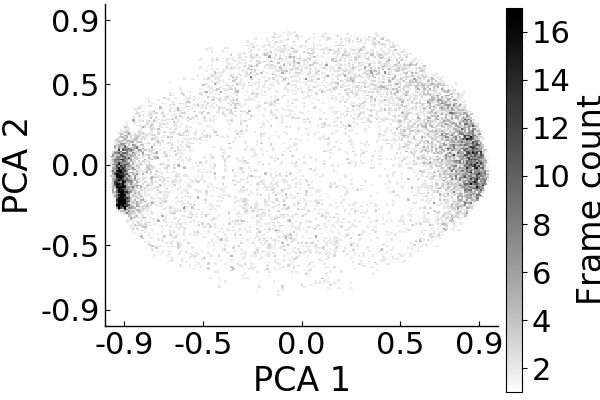

In [13]:
plt_2his = histogram2d(smooth_prj_1_lig, smooth_prj_2_lig, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    seriescolor = :gray_r,
    guidefont = font(24, "Helvetica"), tickfont = font(22, "Helvetica"),
    legendfont = font(22, "Helvetica"),
    
    clim = (1, 17),
    nbins = 180, grid = false)

In [14]:
savefig(plt_2his, joinpath(rtdos, "papel", "5", string("5_PCAHis_", pdb, "_lig.svg")))

## Separo las poblaciones según PCA

In [20]:
idx_lig_0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig0")))[:, 1])
idx_lig_1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_lig1")))[:, 1])

# Leo volumen
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Estiro el volumen 
full_trj_vol = Array{Float64}(undef, length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_lig_0]
trj_vol1 = full_trj_vol[idx_lig_1];

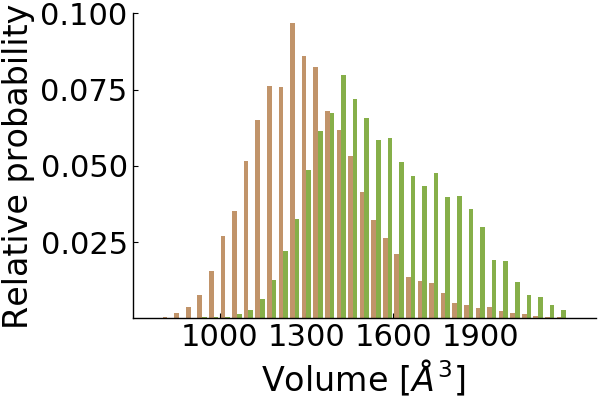

In [35]:
st = 40
fa = .9
bin_range = 800:st:2200
bin_lig = collect(bin_range)

# Histograma ponderado
wgh_lig = fill(1.0, length(trj_vol0))
bin_lig0_4xcp, his_lig0_4xcp = JUMD.weightedHist(trj_vol0, bin_lig, wgh_lig, true, false);
wgh_lig = fill(1.0, length(trj_vol1))
bin_lig1_4xcp, his_lig1_4xcp = JUMD.weightedHist(trj_vol1, bin_lig, wgh_lig, true, false);

grp = repeat(["Straight", "Bent"], inner = length(bin_lig1_4xcp))
clr = repeat([colorant"#86af49", colorant"#c1946a"], inner = length(bin_lig1_4xcp))

plt_his_vols = groupedbar(
    repeat(bin_lig1_4xcp, outer = 2), hcat(his_lig0_4xcp, his_lig1_4xcp),
    group = grp, 
    fillcolor = clr,
    xticks = 1E3:300:2E3, yticks = .025:.025:.1,
    xlims = (700, 2300),
#     xlims = (700, 3200),
    ylims = (0, .1),
    
    linecolor = false, grid = false,
    legend = false,
#     legend = (.9, .95),
    guidefont = font(24, "Helvetica"), tickfont = font(22, "Helvetica"),
    legendfont = font(22, "Helvetica"),
    yaxis = "Relative probability", xaxis = L"Volume $[\AA^3]$ ")

In [36]:
savefig(plt_his_vols, joinpath(rtdos, "papel", "5", string("5_VolHis_", pdb, "_lig.svg")))
# savefig(plt_his_vols, joinpath(rtdos, "papel", "5", string("5_legend_", pdb, "_lig.svg")))

In [14]:
df_datos = hcat([ mean(trj_vol0) ; mean(trj_vol1) ],
    [ std(trj_vol0) ; std(trj_vol1) ])

2×2 Array{Float64,2}:
 1570.7   229.796
 1324.15  204.376

In [29]:
trj_vol0_smooth = [ mean(trj_vol0[i:i+10]) for i = 1:10:length(trj_vol0)-9 ]
trj_vol1_smooth = [ mean(trj_vol1[i:i+10]) for i = 1:10:length(trj_vol1)-9 ]

idx_lig0_smooth = [ idx_lig_0[i] for i = 1:10:length(idx_lig_0)-9 ]
idx_lig1_smooth = [ idx_lig_1[i] for i = 1:10:length(idx_lig_1)-9 ]

grupos = [ fill("Straight", length(idx_lig0_smooth)) ; fill("Bent", length(idx_lig1_smooth)) ];

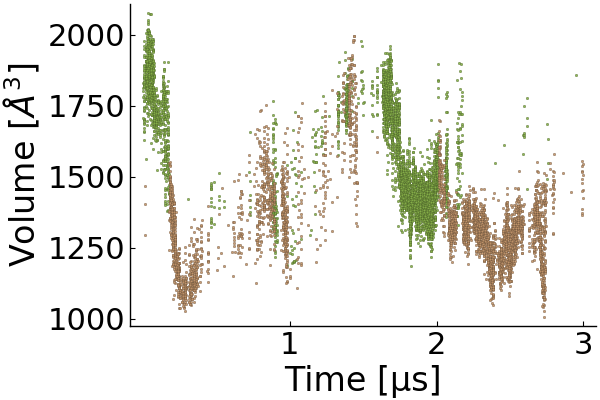

In [30]:
y_sm = JUMD.suave(trj_vol, 75)
x_sm = range(1, stop = nframes, length = length(y_sm))

ma = .9
plt_vol_pop = scatter()

scatter!(idx_lig0_smooth, trj_vol0_smooth,  label = "Straight",
    markersize = 2., markeralpha = ma, markerstrokewidth = .1,
    seriescolor = colorant"#86af49",
    xticks = (1E5:1E5:3E5, ["1", "2", "3"]),
    grid = false,
    legend = false,
    guidefont = font(24, "Helvetica"), tickfont = font(22, "Helvetica"),
    legendfont = font(22, "Helvetica"),
    yaxis = L"Volume $[\AA^{3}]$", xaxis = "Time [μs]")

scatter!(idx_lig1_smooth, trj_vol1_smooth, label = "Bent",
    markersize = 2., markeralpha = ma, markerstrokewidth = .1,
    seriescolor = colorant"#c1946a")

In [31]:
savefig(plt_vol_pop, joinpath(rtdos, "papel", "5", string("5_Vol_", pdb, "_lig.svg")))

## Comparo con los índices separados por proteína

In [11]:
idx_prt1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol1")))[:, 1])
idx_prt2 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol2")))[:, 1])
idx_prt3 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_idx_vol3")))[:, 1])
# Junto
idx_prt23 = [ idx_prt2 ; idx_prt3 ]

trj_vol_prt1 = full_trj_vol[idx_prt1]
trj_vol_prt2 = full_trj_vol[idx_prt2]
trj_vol_prt3 = full_trj_vol[idx_prt3]
trj_vol_prt23 = full_trj_vol[idx_prt23];

st = 40
bw = 28
fa = .7
bin_range = 700:st:2300
bin_vol = collect(bin_range)

wgh_lig = fill(1.0, length(trj_vol_prt1))
bin_vol_prt1, his_vol_prt1 = JUMD.WeightedHist(trj_vol_prt1, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt2))
bin_vol_prt2, his_vol_prt2 = JUMD.WeightedHist(trj_vol_prt2, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt3))
bin_vol_prt3, his_vol_prt3 = JUMD.WeightedHist(trj_vol_prt3, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol_prt23))
bin_vol_prt23, his_vol_prt23 = JUMD.WeightedHist(trj_vol_prt23, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol0))
bin_lig0_4xcp, his_lig0_4xcp = JUMD.WeightedHist(trj_vol0, bin_lig, wgh_lig, true, false);

wgh_lig = fill(1.0, length(trj_vol1))
bin_lig1_4xcp, his_lig1_4xcp = JUMD.WeightedHist(trj_vol1, bin_lig, wgh_lig, true, false);

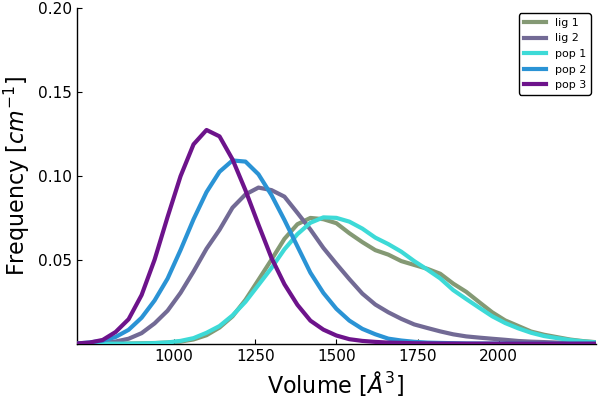

In [12]:
# Suavizado
m_ = 2
ash_vol_0 = ash(trj_vol0, rng = bin_range, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_0 = xy(ash_vol_0)
xy_ash_vol_0[2][:] = xy_ash_vol_0[2] .*  (maximum(his_lig0_4xcp) / maximum(xy_ash_vol_0[2]))

ash_vol_1 = ash(trj_vol1, rng = bin_range, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_1 = xy(ash_vol_1)
xy_ash_vol_1[2][:] = xy_ash_vol_1[2] .*  (maximum(his_lig1_4xcp) / maximum(xy_ash_vol_1[2]))

ash_vol_prt1 = ash(trj_vol_prt1, rng = bin_range, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_prt1 = xy(ash_vol_prt1)
xy_ash_vol_prt1[2][:] = xy_ash_vol_prt1[2] .*  (maximum(his_vol_prt1) / maximum(xy_ash_vol_prt1[2]))

ash_vol_prt2 = ash(trj_vol_prt2, rng = bin_range, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_prt2 = xy(ash_vol_prt2)
xy_ash_vol_prt2[2][:] = xy_ash_vol_prt2[2] .*  (maximum(his_vol_prt2) / maximum(xy_ash_vol_prt2[2]))

ash_vol_prt3 = ash(trj_vol_prt3, rng = bin_range, m = 3, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_prt3 = xy(ash_vol_prt3)
xy_ash_vol_prt3[2][:] = xy_ash_vol_prt3[2] .*  (maximum(his_vol_prt3) / maximum(xy_ash_vol_prt3[2]))

plt_his_vols = plot(xy_ash_vol_0, linecolor = colorant"#849974",
    label = "lig 1", linewidth = 3, 
    
    xticks = 1E3:250:2E3, yticks = .05:.05:.2,
    xlims = (700, 2300), ylims = (0, .2),
    legend = (.9, .95), grid = false,
    
    guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ")

plot!(xy_ash_vol_1, linecolor = colorant"#726a95", label = "lig 2", linewidth = 3)
plot!(xy_ash_vol_prt1, linecolor = colorant"#3DDAD7", label = "pop 1", linewidth = 3)
plot!(xy_ash_vol_prt2, linecolor = colorant"#2A93D5", label = "pop 2", linewidth = 3)
plot!(xy_ash_vol_prt3, linecolor = colorant"#6d138b", label = "pop 3", linewidth = 3)

In [173]:
savefig(plt_his_vols, joinpath(rtdos, "papel", "4", string("4_VolHis_", pdb, "_prt_lig.svg")))

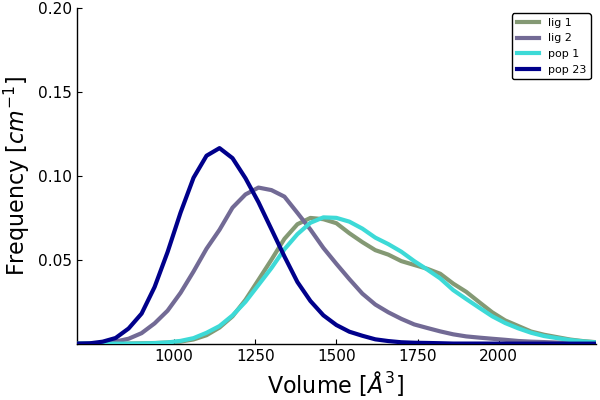

In [13]:
ash_vol_prt23 = ash(trj_vol_prt23, rng = bin_range, m = m_, kernel = AverageShiftedHistograms.Kernels.gaussian)
xy_ash_vol_prt23 = xy(ash_vol_prt23)
xy_ash_vol_prt23[2][:] = xy_ash_vol_prt23[2] .*  (maximum(his_vol_prt23) / maximum(xy_ash_vol_prt23[2]))

plt_his_vols = plot(xy_ash_vol_0, linecolor = colorant"#849974", label = "lig 1", linewidth = 3, 
    
    xticks = 1E3:250:2E3, yticks = .05:.05:.2,
    xlims = (700, 2300), ylims = (0, .2),
    legend = (.9, .95), grid = false,
    
    guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ")

plot!(xy_ash_vol_1, linecolor = colorant"#726a95", label = "lig 2", linewidth = 3)
plot!(xy_ash_vol_prt1, linecolor = colorant"#3DDAD7", label = "pop 1", linewidth = 3)
plot!(xy_ash_vol_prt23, linecolor = colorant"#00008B", label = "pop 23", linewidth = 3)

### RMSD de lig en poblaciones prot. Guardo el frame más similar al avg

#### RMSD de lig en poblaciones lig. Guardo el frame más similar al avg